# Tracking of a Spherical Colloid with Holopy

The aim of this Jupyter Notebook is to use the Holopy (see GitHub: manoharan-lab/holopy) repository to obtain the 3D trajectory of a spherical colloid from an experimental Mie-holography video. 

Objectives include: 
 - Comparing Holopy and Pylorenzmie (see Github: davidgrier/pylorenzmie).
 - Understanding how Holopy works.

The code focuses first on a theoretical image, then on an experimental video. The third part is dedicated to defining manually the model of the scatterer (here a sphere), in order to be able to adapt the code to a more complex scatterer (_e.g._ a spheroid).

# Importations & Auxiliary Functions

## Importations

In [1]:
import numpy as np

import imageio

import pandas as pd
import seaborn as sns
import scipy.stats as st

import os 
import sys
import copy
from tqdm import tqdm

In [2]:
import utilities

In [3]:
# Holopy
import holopy as hp
# Utilities
from holopy.core.io import load_average
from holopy.core.process import bg_correct, subimage, normalize, center_find
# Define Scatterers
from holopy.scattering import Sphere #, Spheres, Cylinder
# from holopy.scattering.scatterer import Spheroid
# from holopy.scattering.scatterer import Capsule
# Theories
from holopy.scattering import Mie
from holopy.scattering.theory import Tmatrix
from holopy.scattering.theory.dda import DDA
# Compute holograms and fit
from holopy.scattering import calc_holo
from holopy.inference import CmaStrategy
from holopy.inference import prior, NmpfitStrategy, ExactModel

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib as mpl
from matplotlib import rc
import matplotlib.colors as mplcolors
from mpltools import annotation

rc('lines', linewidth=1.5, markeredgecolor='k', markeredgewidth=0.5)
rc('xtick', direction='in', labelsize=9)
rc('ytick', direction='in', labelsize=9)

rc('font', family='serif', size=9)
rc('text', usetex=True)

rc('figure', dpi=200)
rc('savefig', dpi=600)

## Auxiliary Function: azimutal average

In [5]:
# Adapted from pylorenzmie

def aziavgstd(data, center):
    '''Azimuthal average and standard deviation of data about center
    
    Parameters
    ----------
    data : array_like
        image data
    center : tuple
        (x_p, y_p) center of azimuthal average

    Returns
    -------
    avg : array_like
        One-dimensional azimuthal average of data about center
    std : array_like
        Standard deviation from the mean
    '''
    x_p, y_p = center
    ny, nx, _ = data.shape
    x = np.arange(nx) - x_p
    y = np.arange(ny) - y_p
    
    d = data.ravel()
    r = np.hypot.outer(y, x).astype(int).ravel()
    nr = np.bincount(r)
    avg = np.bincount(r, d) / nr
    std = np.sqrt(np.bincount(r, (d - avg[r])**2) / nr)
    rad = np.arange(len(avg))
    return rad, avg, std

# Inputs

In [6]:
# Optics & Camera
spacing = 0.05799
fps = 100

In [7]:
# Light
illum_polarization = (1, 0)
illum_wavelen = 0.532
medium_index = 1.33

In [8]:
# Path to an experimental video 
vid_path = '../test_tracking/Basler_acA1920-155um__22392621__20230310_132632377.mp4' #'./vid_PS_diffusing/Basler_acA1920-155um__22392621__20230310_132632377.mp4'

In [9]:
vid = utilities.video_reader(vid_path)

In [10]:
n_start = 0
n_stop = vid.get_length()
print(n_stop)

126443


# Before Experimental Images: a Theoretical Image

In [11]:
h = 500 # px

# Create the theoretical image
theory = Mie
detector = hp.detector_grid(shape=h, spacing=spacing)
s1 = Sphere(center=(h//2*spacing, h//2*spacing, 12), n = 1.59, r = 1.48) # x, y, z in um
holo = calc_holo(detector, s1, 
                 medium_index, illum_wavelen, illum_polarization, 
                 theory=theory, 
                )

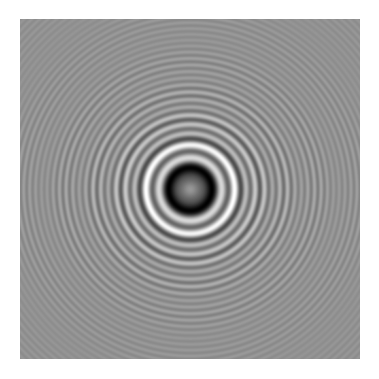

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5/2.54,5/2.54))
ax.imshow(holo, cmap='gray')
ax.axis('off')
plt.tight_layout()
plt.show()

In [15]:
# Find approximate center
xc, yc = center_find(holo, centers=1, threshold=0.5, blursize=3)

In [16]:
# Crop
hc = 200
holo_c = subimage(holo, [yc,xc], hc)
holo_c = normalize(holo_c)

In [17]:
# holo_c

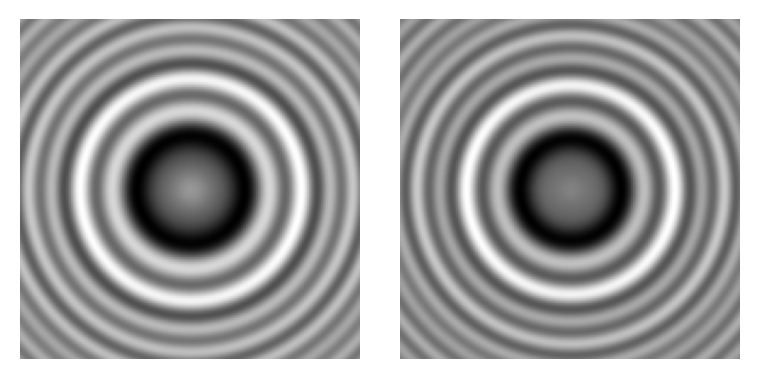

In [39]:
# Initial guess
guess_sphere = Sphere(center=[yc*spacing, xc*spacing, 11], r=1.49, n=1.59)
holo_guess = calc_holo(holo_c, guess_sphere)

# Plot
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(10/2.54,5/2.54))
ax1.imshow(holo_c.data, cmap='gray')
ax2.imshow(holo_guess.data, cmap='gray')
ax1.axis('off')
ax2.axis('off')
plt.tight_layout()
plt.show()

In [40]:
%%time

# Fit 
parameters_to_fit = ['x', 'y', 'z', 'r', 'n']

# Define the fitting strategy

percent_px = 0.1

fit_strategy = NmpfitStrategy()
fit_strategy.npixels = int(percent_px * hc ** 2)

# Fit
fit_result = hp.fit(holo_c, guess_sphere, strategy=fit_strategy, parameters=parameters_to_fit)

CPU times: user 917 ms, sys: 0 ns, total: 917 ms
Wall time: 917 ms


In [69]:
%%time

x = prior.Uniform(lower_bound=(xc-5)*spacing, upper_bound=(xc+5)*spacing, guess=(xc)*spacing)
y = prior.Uniform(lower_bound=(yc-5)*spacing, upper_bound=(yc+5)*spacing, guess=(yc)*spacing)
z = prior.Uniform(10, 20, 13)
r = prior.Uniform(1.47, 1.49, 1.48)
n = prior.Uniform(1.57, 1.61, 1.59)

guess_sphere = Sphere(center=[x, y, z], r=r, n=n)

theory = Mie()

# Define the model 
model = ExactModel(
    scatterer=guess_sphere, calc_func=calc_holo, 
    noise_sd=None, 
    medium_index=medium_index, illum_wavelen=illum_wavelen, illum_polarization=illum_polarization, 
    theory=theory,
    constraints=[], 
    )

percent_px = 0.1

fit_strategy = CmaStrategy(popsize=50)
fit_strategy.npixels = int(percent_px * hc ** 2)
fit_strategy.resample_pixels = True
fit_strategy.parallel = 20 #'mpi'
fit_strategy.seed = 10
# fit_strategy.walker_initial_pos = [0, np.inf]

# Fit
fit_result = hp.fit(holo_c, model=model, strategy=fit_strategy)

CPU times: user 1 s, sys: 2.73 s, total: 3.73 s
Wall time: 2.6 s


In [70]:
holo_f = fit_result.hologram

{'n': 1.5895649260960127, 'r': 1.4821849900739303, 'center.0': 14.497899883191563, 'center.1': 14.497967894462006, 'center.2': 12.00632184191292}


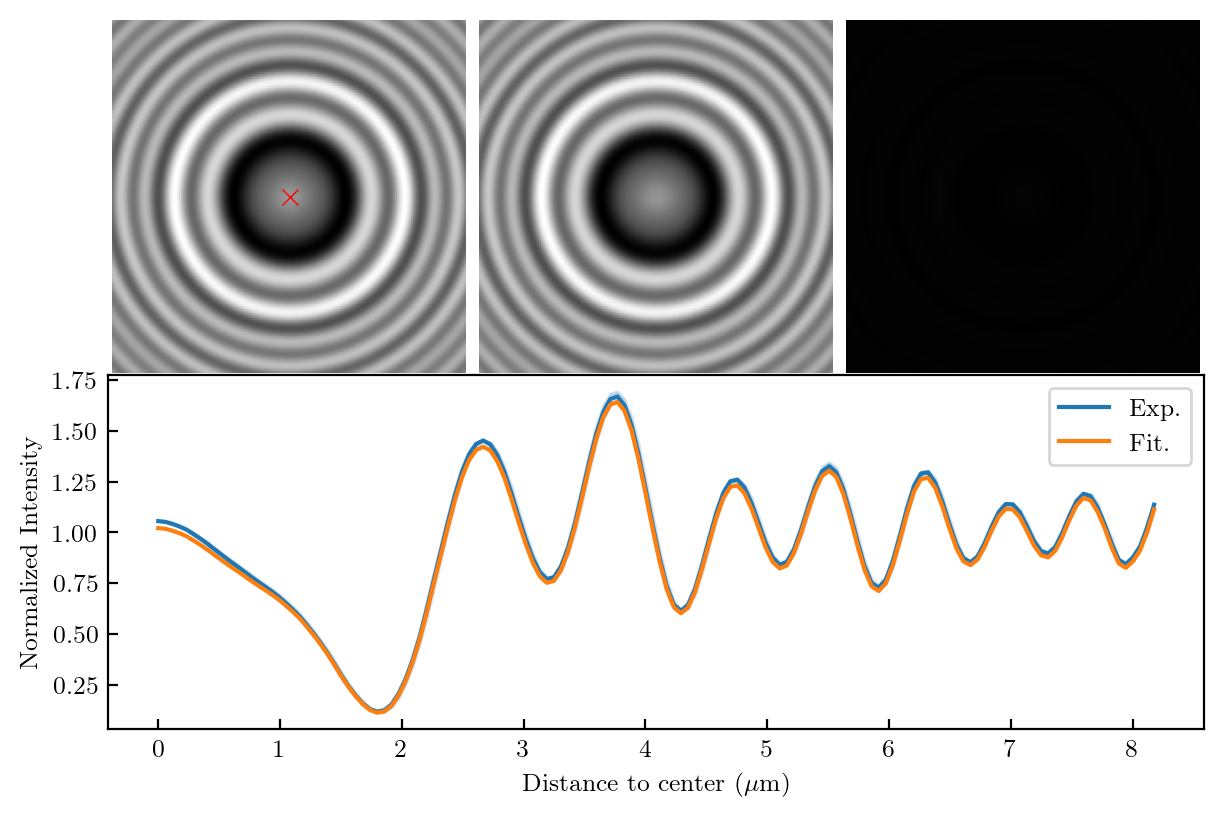

In [71]:
print(fit_result.parameters)

fig = plt.figure(figsize=(15/2.54,10/2.54))
nlin, ncol = 2, 3

# Plot images
ax1 = fig.add_subplot(nlin, ncol, 1)
ax2 = fig.add_subplot(nlin, ncol, 2)
ax3 = fig.add_subplot(nlin, ncol, 3)
ax1.imshow(holo_c.data, cmap='gray')
ax2.imshow(holo_f, cmap='gray')
ax3.imshow(np.abs(holo_c.data - holo_f.data), cmap='gray', vmin=0, vmax=2)
for ax in [ax1, ax2, ax3]:
    ax.axis('off')

# Compute radial intensity profiles 
expe_rad, expe_avg, expe_std = aziavgstd(holo_c.data, [hc//2, hc//2]) 
theo_rad, theo_avg, _ = aziavgstd(holo_f.data, [hc//2, hc//2]) 
expe_rad = expe_rad * spacing 
theo_rad = theo_rad * spacing 

ax1.plot(hc//2, hc//2, marker='x', mec='r')

# Plot radial intensity profile
ax4 = fig.add_subplot(nlin, ncol, (4,6))
ax4.plot(expe_rad, expe_avg, ls='-', c='tab:blue', label='Exp.')
ax4.fill_between(expe_rad, expe_avg-expe_std, expe_avg+expe_std, color='tab:blue', alpha=0.2)
ax4.plot(theo_rad, theo_avg, ls='-', c='tab:orange', label='Fit.')
ax4.legend()
ax4.set(xlabel=r'Distance to center ($\mathrm{\mu m}$)', ylabel=r'Normalized Intensity')
plt.tight_layout(pad=0.2)
plt.show()

In [87]:
%%time

# Fit 

# Parameters you want to fit are defined as prior guesses 
x_p = prior.BoundedGaussian(xc*spacing, 0.1, lower_bound=xc*spacing-2, upper_bound=xc*spacing+2) #prior.Uniform(lower_bound=xc*spacing-5, upper_bound=xc*spacing+5, guess=xc*spacing)
y_p = prior.BoundedGaussian(yc*spacing, 0.11, lower_bound=yc*spacing-2, upper_bound=yc*spacing+2) #prior.Uniform(lower_bound=yc*spacing-5, upper_bound=yc*spacing+5, guess=yc*spacing)
z_p = prior.BoundedGaussian(11.5, 1, lower_bound=10, upper_bound=14) #prior.Uniform(lower_bound=10, upper_bound=14, guess=11)
a_p = prior.BoundedGaussian(1.49, 0.01, lower_bound=1.47, upper_bound=1.51) #prior.Uniform(1.47, 1.51, 1.48)
n_p = prior.BoundedGaussian(1.59, 0.01, lower_bound=1.57, upper_bound=1.61) #prior.Uniform(1.57, 1.61, 1.59)

# Define the scatterer
par_scatterer = Sphere(n=n_p, r=a_p, center=(x_p, y_p, z_p))

# Define the theory
theory = Mie()

# Define the model 
model = ExactModel(
    scatterer=par_scatterer, calc_func=calc_holo, 
    noise_sd=0.1, 
    medium_index=medium_index, illum_wavelen=illum_wavelen, illum_polarization=illum_polarization, 
    theory=theory,
    constraints=[], 
    )

# Define the fitting strategy
fit_strategy = CmaStrategy(popsize=50)
percent_px = 0.1
fit_strategy.npixels = int(percent_px * hc ** 2)
fit_strategy.resample_pixels = True
fit_strategy.parallel = 20 #'mpi'
fit_strategy.seed = 1000

# Fit
fit_result = hp.fit(holo_c, model=model, strategy=fit_strategy) 


CPU times: user 1.03 s, sys: 2.69 s, total: 3.72 s
Wall time: 2.67 s


In [82]:
holo_f = fit_result.hologram

{'n': 1.5895574268928339, 'r': 1.4817377103105478, 'center.0': 14.496736077572535, 'center.1': 14.49759083413906, 'center.2': 12.004919197272345}


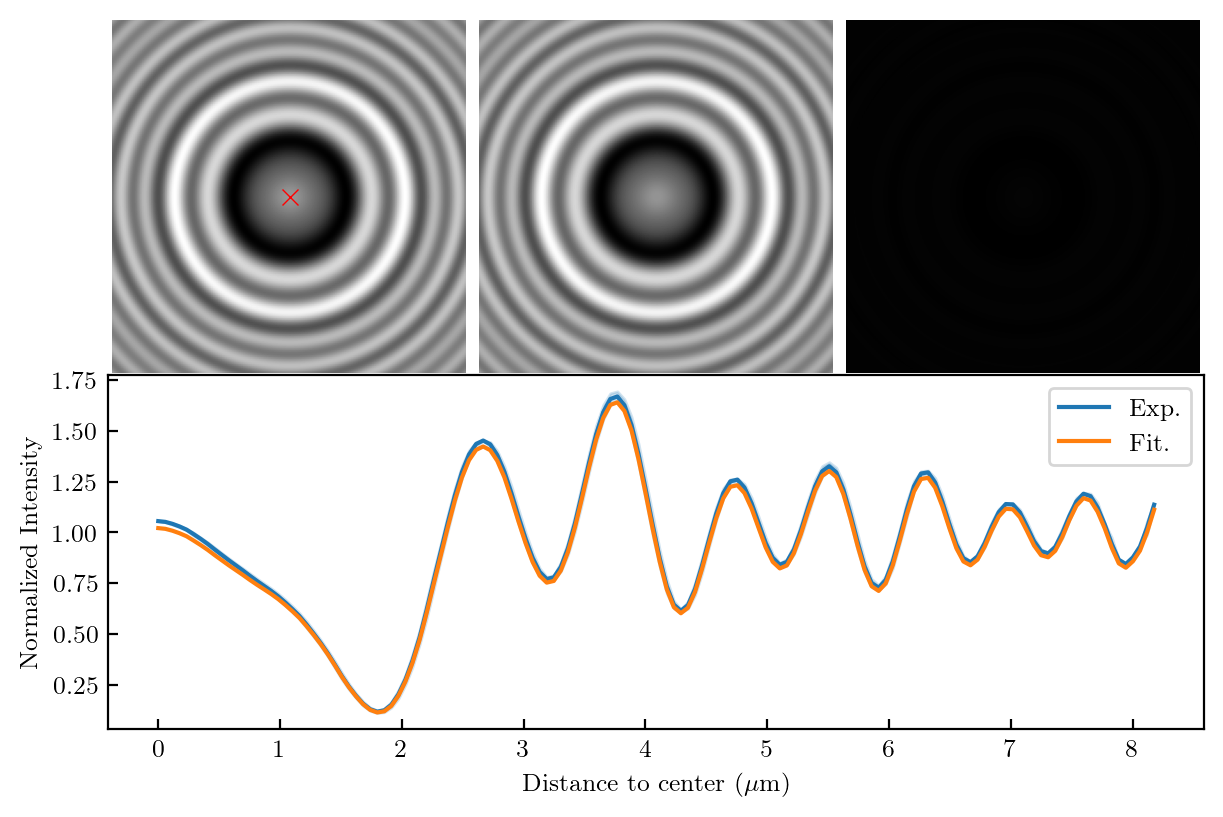

In [83]:
print(fit_result.parameters)

fig = plt.figure(figsize=(15/2.54,10/2.54))
nlin, ncol = 2, 3

# Plot images
ax1 = fig.add_subplot(nlin, ncol, 1)
ax2 = fig.add_subplot(nlin, ncol, 2)
ax3 = fig.add_subplot(nlin, ncol, 3)
ax1.imshow(holo_c.data, cmap='gray')
ax2.imshow(holo_f, cmap='gray')
ax3.imshow(np.abs(holo_c.data - holo_f.data), cmap='gray', vmin=0, vmax=2)
for ax in [ax1, ax2, ax3]:
    ax.axis('off')

# Compute radial intensity profiles 
expe_rad, expe_avg, expe_std = aziavgstd(holo_c.data, [hc//2, hc//2]) 
theo_rad, theo_avg, _ = aziavgstd(holo_f.data, [hc//2, hc//2]) 
expe_rad = expe_rad * spacing 
theo_rad = theo_rad * spacing 

ax1.plot(hc//2, hc//2, marker='x', mec='r')

# Plot radial intensity profile
ax4 = fig.add_subplot(nlin, ncol, (4,6))
ax4.plot(expe_rad, expe_avg, ls='-', c='tab:blue', label='Exp.')
ax4.fill_between(expe_rad, expe_avg-expe_std, expe_avg+expe_std, color='tab:blue', alpha=0.2)
ax4.plot(theo_rad, theo_avg, ls='-', c='tab:orange', label='Fit.')
ax4.legend()
ax4.set(xlabel=r'Distance to center ($\mathrm{\mu m}$)', ylabel=r'Normalized Intensity')
plt.tight_layout(pad=0.2)
plt.show()

# Compute the Background

In [20]:
_, background = vid.get_background(n=20, first_im=n_start, last_im=n_stop)
background += 1
vid.background += 1

(21, 1200, 1200)


100%|█████████████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  3.00it/s]


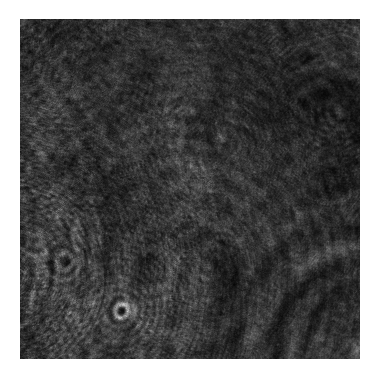

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(5/2.54, 5/2.54))
ax.imshow(background, cmap='gray')
ax.axis('off')
plt.tight_layout()
plt.show()
# fig.savefig('background.pdf')

In [22]:
background.shape

(1200, 1200)

In [23]:
%%time 

# Create a Holopy object with the appropriate dimensions

# Size of the box
h = background.shape[0]

# Set the theory
theory = Mie
# Define the detector
detector = hp.detector_grid(shape=h, spacing=spacing)
# Define the scatterer
s1 = Sphere(center=(h//2*spacing, h//2*spacing, 12), n = 1.59, r = 1.48) # x, y, z in um
# Define the holopy object
background = calc_holo(detector, s1, 
    medium_index, illum_wavelen, illum_polarization, 
    theory=theory, 
)
# Replace the data by the experimental image
background.data[:,:,0] = copy.deepcopy(vid.background)

CPU times: user 7.04 s, sys: 92.6 ms, total: 7.14 s
Wall time: 7.07 s


In [ ]:
# imagepath = get_example_data_path('image01.jpg')
# raw_holo = hp.load_image(imagepath, spacing = 0.0851, medium_index = 1.33,
#                          illum_wavelen = 0.66, illum_polarization = (1,0))
# bgpath = get_example_data_path(['bg01.jpg','bg02.jpg','bg03.jpg'])
# bg = load_average(bgpath, refimg = raw_holo)
# data_holo = bg_correct(raw_holo, bg)

# Work On One Image

In [24]:
index = 50000
# Get the image 
im_raw = vid.get_image(index)
# Remove background and normalize 
im_fin = utilities.normalize(im_raw, vid.background, dark_count=0)

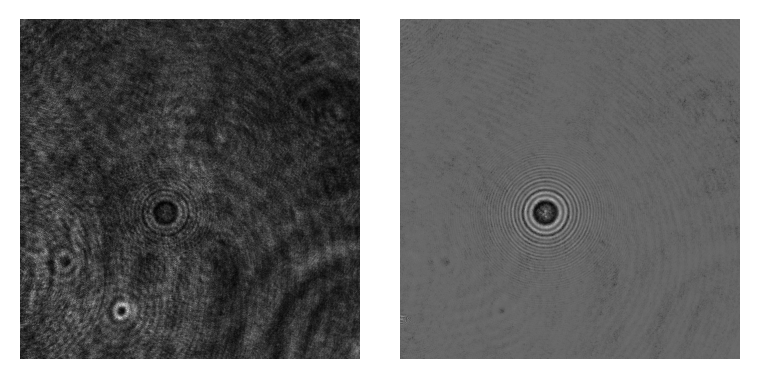

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10/2.54, 5/2.54))
axes[0].imshow(im_raw, cmap='gray')
axes[1].imshow(im_fin, cmap='gray')
for i, ax in enumerate(axes):
    ax.axis('off')
plt.tight_layout()
plt.show()

In [26]:
# imageio.imsave('test.jpg', im_raw)

In [27]:
%%time

# Create a Holopy object with the appropriate dimensions
# Set the theory
theory = Mie
# Define the detector
detector = hp.detector_grid(shape=h, spacing=spacing)
# Define the scatterer
s1 = Sphere(center=(h//2*spacing, h//2*spacing, 12), n = 1.59, r = 1.48) # x, y, z in um
# Define the holopy object
holo_raw = calc_holo(detector, s1, 
    medium_index, illum_wavelen, illum_polarization, 
    theory=theory, 
)
# Replace the data by the experimental image
holo_raw.data[:,:,0] = copy.deepcopy(im_raw)

CPU times: user 7.11 s, sys: 64.2 ms, total: 7.17 s
Wall time: 7.14 s


In [28]:
holo = bg_correct(holo_raw, background, df=None)

In [29]:
# Find approximate center
xc, yc = center_find(holo, centers=1, threshold=0.5, blursize=3)
# Crop and normalize
hc = 200
holo_c = subimage(holo, [xc, yc], hc)
holo_c = normalize(holo_c)

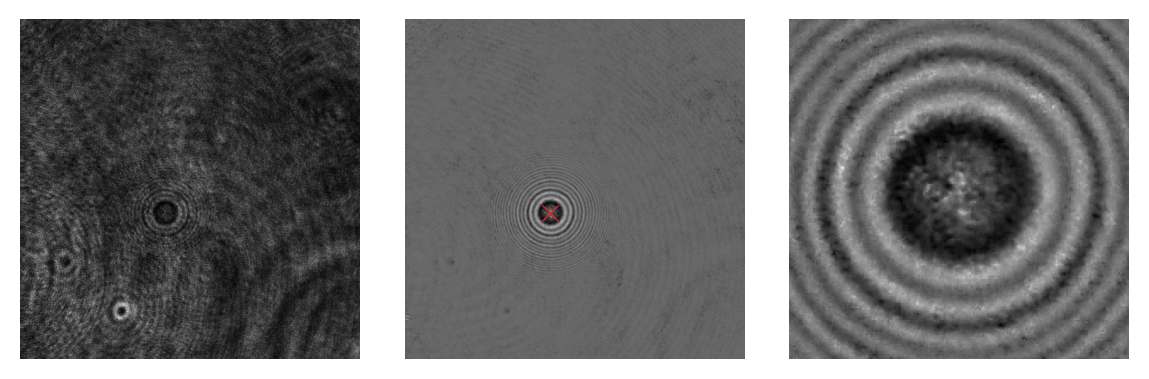

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(15/2.54, 5/2.54))
axes[0].imshow(holo_raw.data, cmap='gray')
axes[1].imshow(holo.data, cmap='gray')
axes[1].plot(yc, xc, marker='x', mec='tab:red')
axes[2].imshow(holo_c.data, cmap='gray')
for i, ax in enumerate(axes):
    ax.axis('off')
plt.tight_layout()
plt.show()

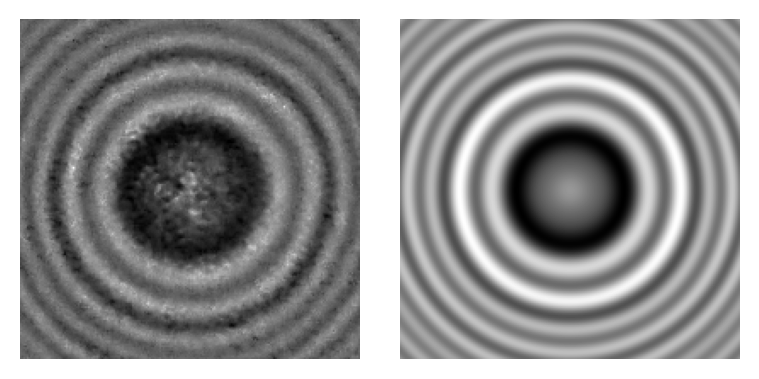

In [31]:
# Initial guess
guess_sphere = Sphere(center=[xc*spacing, yc*spacing, 12], r=1.48, n=1.59)
holo_guess = calc_holo(holo_c, guess_sphere)

# Plot
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(10/2.54,5/2.54))
ax1.imshow(holo_c.data, cmap='gray')
ax2.imshow(holo_guess.data, cmap='gray')
ax1.axis('off')
ax2.axis('off')
plt.tight_layout()
plt.show()

In [32]:
%%time

# Fit 
parameters_to_fit = ['x', 'y', 'z', 'r', 'n']

# Define the fitting strategy
fit_strategy = NmpfitStrategy()
percent_px = 0.2
fit_strategy.npixels = int(percent_px * hc ** 2)

# Fit
fit_result0 = hp.fit(holo_c, guess_sphere, parameters=parameters_to_fit, strategy=fit_strategy)

CPU times: user 2.99 s, sys: 21.6 ms, total: 3.01 s
Wall time: 2.99 s


{'n': 1.5817514046933359, 'r': 1.4796844310562376, 'x': 39.61900886053058, 'y': 29.783006622194147, 'z': 13.60619060563339, 'alpha': 1.0}


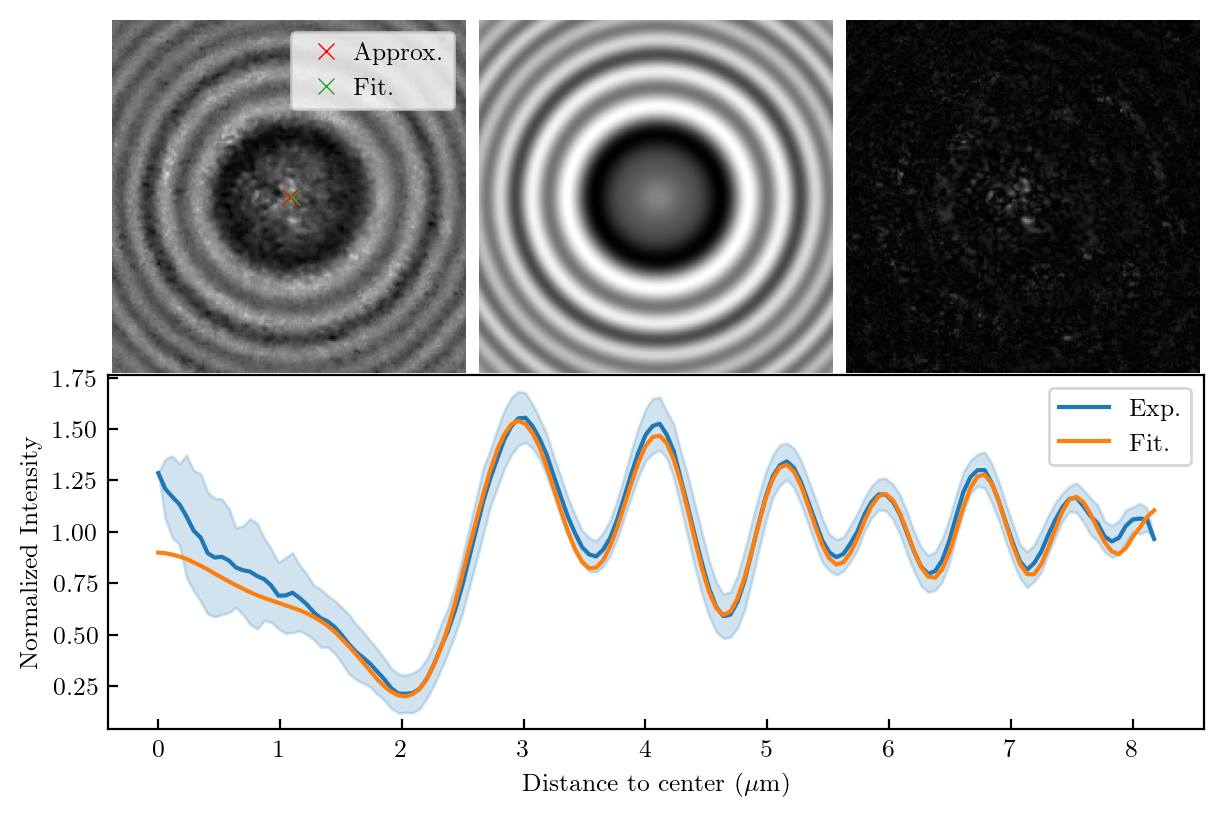

In [33]:
print(fit_result0.parameters)

holo_f = fit_result0.hologram

fig = plt.figure(figsize=(15/2.54,10/2.54))
nlin, ncol = 2, 3

# Plot images
ax1 = fig.add_subplot(nlin, ncol, 1)
ax2 = fig.add_subplot(nlin, ncol, 2)
ax3 = fig.add_subplot(nlin, ncol, 3)
ax1.imshow(holo_c.data, cmap='gray')
ax2.imshow(holo_f, cmap='gray')
ax3.imshow(np.abs(holo_c.data - holo_f.data), cmap='gray', vmin=0, vmax=2)
for ax in [ax1, ax2, ax3]:
    ax.axis('off')

# Compute radial intensity profiles 
expe_rad, expe_avg, expe_std = aziavgstd(holo_c.data, [hc//2, hc//2]) 
theo_rad, theo_avg, _ = aziavgstd(holo_f.data, [hc//2, hc//2]) 
expe_rad = expe_rad * spacing 
theo_rad = theo_rad * spacing 

ax1.plot(hc//2, hc//2, ls='', marker='x', mec='r', label='Approx.')
ax1.plot(fit_result0.parameters['y']/spacing - yc + hc//2, fit_result0.parameters['x']/spacing - xc + hc//2, ls='', marker='x', mec='tab:green', label='Fit.')
ax1.legend(handletextpad=0.1)

# Plot radial intensity profile
ax4 = fig.add_subplot(nlin, ncol, (4,6))
ax4.plot(expe_rad, expe_avg, ls='-', c='tab:blue', label='Exp.')
ax4.fill_between(expe_rad, expe_avg-expe_std, expe_avg+expe_std, color='tab:blue', alpha=0.2)
ax4.plot(theo_rad, theo_avg, ls='-', c='tab:orange', label='Fit.')
ax4.legend()
ax4.set(xlabel=r'Distance to center ($\mathrm{\mu m}$)', ylabel=r'Normalized Intensity')
plt.tight_layout(pad=0.2)
plt.show()

In [34]:
# /!\ Switching between x and y compared to vid.
# x from Holopy = usual y

# fit_result gives positions in the initial image

# Work on Several Images

In [35]:
def full2crop(holo, hc=200):
    # Find approximate center
    xc, yc = center_find(holo, centers=1, threshold=0.5, blursize=3)
    # Crop and normalize
    holo_c = subimage(holo, [xc, yc], hc)
    holo_c = normalize(holo_c)
    return holo_c, xc, yc

In [38]:
# Where to fit
start = index #40000
stop = index + 10 #41000
frequency = 1

Nfits = int((stop - start) // frequency)

# Initial guess = result of the previous fit
guess_sphere = Sphere(center=[fit_result0.parameters['x'], fit_result0.parameters['y'], fit_result0.parameters['z']], r=fit_result0.parameters['r'], n=fit_result0.parameters['n'])

# Initialize storage 
storage = pd.DataFrame(index=np.arange(start, stop, frequency), columns=parameters_to_fit)

for i in tqdm(range(start, stop, frequency)):
    im_raw = vid.get_image(i)
    # Replace the data by the experimental image
    holo_raw.data[:,:,0] = copy.deepcopy(im_raw)
    # Remove the background
    holo = bg_correct(holo_raw, background, df=None)
    # Crop and normalize
    holo_c, xc, yc = full2crop(holo, hc=hc)
    # Fit 
    fit_result = hp.fit(holo_c, guess_sphere, parameters=parameters_to_fit, strategy=fit_strategy)
    # Store the data 
    temp = fit_result.parameters
    temp.pop('alpha')
    for key, value in temp.items():
        storage.loc[i,key] = value
    # Update guess
    # guess_sphere = Sphere(center=[fit_result.parameters['x'], fit_result.parameters['y'], fit_result.parameters['z']], r=fit_result0.parameters['r'], n=fit_result0.parameters['n'])
    guess_sphere = Sphere(center=[xc*spacing, yc*spacing, fit_result.parameters['z']], r=fit_result0.parameters['r'], n=fit_result0.parameters['n'])

100%|█████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.78s/it]


In [39]:
storage.head()

,x,y,z,r,n
50000,39.641581,30.20784,13.98935,1.689003,1.422389
50001,59.704423,20.756282,13.347973,1.451849,1.541633
50002,59.746716,20.599238,11.197277,1.06316,1.620224
50003,59.706893,20.709321,10.33382,1.410196,1.531543
50004,59.737761,20.718742,9.542727,1.327755,1.53802


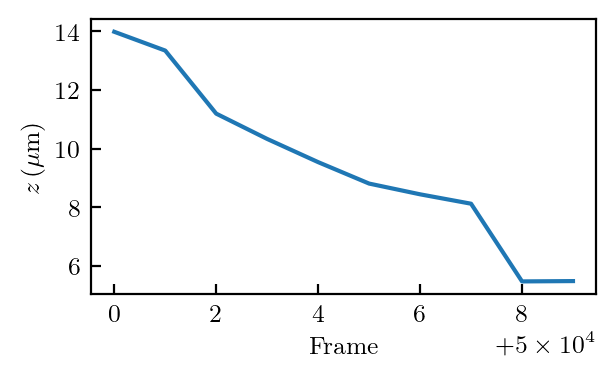

In [272]:
fig, ax = plt.subplots(1, 1, figsize=(8/2.54, 5/2.54))
ax.plot(storage.index, storage['z'])
ax.set(xlabel=r'Frame', ylabel=r"$z \, (\mathrm{\mu m})$")
plt.tight_layout()
plt.show()

In [209]:
# KDE and find most-probable r-n couple

rmin = 1.4
rmax = 1.6

# Get r, n
r = storage['r']
n = storage['n']

# Focus on one region
x = r[(r>=rmin) & (r<=rmax)]
y = n[(r>=rmin) & (r<=rmax)]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j] # create the grid
positions = np.vstack([xx.ravel(), yy.ravel()]) # Ravel the 2D arrays to 1D arrays and stack them
values = np.vstack([x, y]) # Stack 
kernel = st.gaussian_kde(values.astype(np.float64)) # KDE, astype to prevent an error
f = np.reshape(kernel(positions), xx.shape) # Get values of the KDE on the previously-defined grid
f = f/np.max(f) # Normalize

# Most-probable r-n couple
mu_r, sigma_r = np.mean(xx[np.where(f == 1)]), np.std(xx[np.where(f > 0.2)])
mu_n, sigma_n = np.mean(yy[np.where(f == 1)]), np.std(yy[np.where(f > 0.2)])

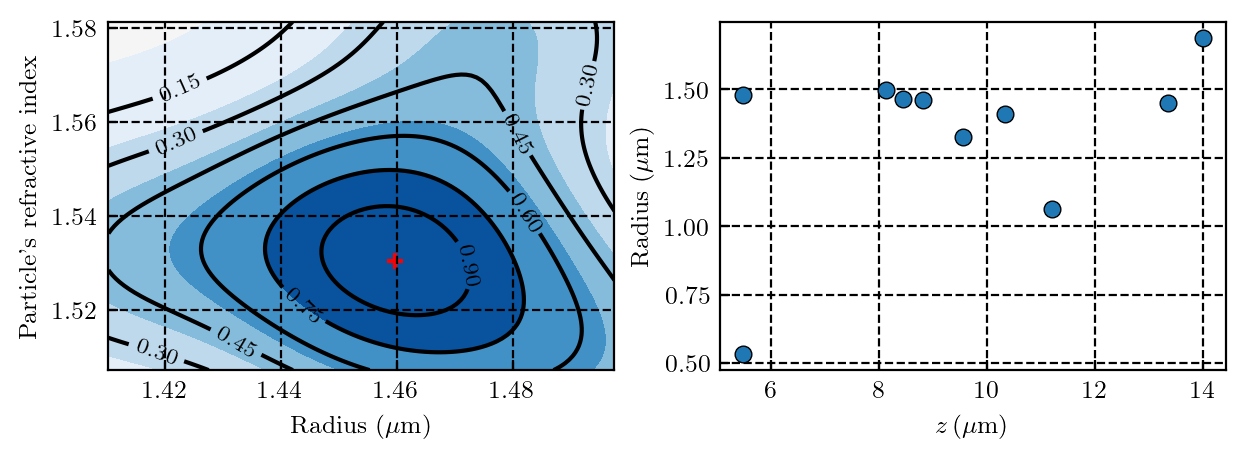

In [211]:
fig, axes = plt.subplots(1, 2, figsize=(16/2.54, 6/2.54))

# By default, seaborn kdeplot uses the same bw method as scipy.stats.gaussian_kde
axes[0].set_facecolor((0.3, 0.3, 0.3, 0.05))
axes[0].grid(visible=True, axis="both", linestyle="--", c='k')
sns.kdeplot(data=storage[(storage['r'] >= rmin) & (storage['r'] <= rmax)], x='r', y='n', hue=None, fill=True, levels=6, cmap='Blues', ax=axes[0])

axes[0].set_xlim(xmin, xmax)
axes[0].set_ylim(ymin, ymax)
# cfset = axes[0].contourf(xx, yy, f, cmap='Blues')
cset = axes[0].contour(xx, yy, f, colors='k')
axes[0].clabel(cset, inline=1, fontsize=8)

axes[0].scatter(mu_r, mu_n, color = "red", marker="+")

axes[0].set(xlabel=r'Radius ($\mathrm{\mu m}$)', ylabel="Particle's refractive index")

axes[1].plot(storage['z'], storage['r'], ls='', marker='o')
axes[1].set(xlabel=r'$z \, \mathrm{(\mu m)}$', ylabel=r'Radius ($\mathrm{\mu m}$)')
axes[1].grid(visible=True, axis="both", linestyle="--", c='k')

plt.tight_layout()
plt.show()

In [212]:
# fig.savefig()

# Optimize the Fitting Procedure

## Multi-Processing in Python Directly

In [203]:
import multiprocessing

import warnings

In [207]:
# Where to fit
start = index #40000
stop = index + 100 #41000
frequency = 1

frames = np.arange(start, stop, frequency)
Nfits = len(frames)
# Nfits = int((stop - start) // frequency)

# Initial guess = result of the previous fit
guess_sphere = Sphere(center=[fit_result0.parameters['x'], fit_result0.parameters['y'], fit_result0.parameters['z']], r=fit_result0.parameters['r'], n=fit_result0.parameters['n'])

# Initialize storage 
storage = pd.DataFrame(index=np.arange(start, stop, frequency), columns=parameters_to_fit)

In [211]:
# Task function
def fit_one_hologram(i, holo_raw=holo_raw, background=background, fit_result0=fit_result0, storage=storage):
    # warnings.simplefilter('error')
    # Get the raw image
    im_raw = vid.get_image(i)
    # Replace the data by the experimental image
    holo_raw.data[:,:,0] = copy.deepcopy(im_raw)
    # Remove the background
    holo = bg_correct(holo_raw, background, df=None)
    # Crop and normalize
    holo_c, xc, yc = full2crop(holo, hc=hc)
    # Update guess
    guess_sphere = Sphere(center=[xc*spacing, yc*spacing, fit_result0.parameters['z']], r=fit_result0.parameters['r'], n=fit_result0.parameters['n'])
    # /!\ fit_result0 for the guesses. It means that the procedure changes compared to what we do with pylorenzmie.
    # Fit 
    fit_result = hp.fit(holo_c, guess_sphere, parameters=parameters_to_fit, strategy=fit_strategy)
    # try:
    #     fit_result = hp.fit(holo_c, guess_sphere, parameters=parameters_to_fit, strategy=fit_strategy)
    # except:
    #     pass
    temp = fit_result.parameters
    temp.pop('alpha')
    for key, value in temp.items():
        storage.loc[i,key] = value
    return i, temp

# Update storage
def _update_storage(i, temp, storage=storage):
    for key, value in temp.items():
        storage.loc[i,key] = value

def update_storage(results, storage=storage):
    for couple in results:
        i, temp = couple
        _update_storage(i, temp, storage=storage)

In [212]:
n_cores = multiprocessing.cpu_count()
print(n_cores)

32


In [146]:
%%time

# Initialize storage 
storage = pd.DataFrame(index=np.arange(start, stop, frequency), columns=parameters_to_fit)

# Serial fitting
results = [] # Initialize temp storage
i=0
for result in map(fit_one_hologram, frames):
    results.append(result)
    print(i, result)
    i+=1

0 (50000, {'n': 1.5820361512591121, 'r': 1.472899142730427, 'x': 39.615866550366526, 'y': 29.796813210288683, 'z': 13.564328452639238})
1 (50001, {'n': 1.5816050278090303, 'r': 1.4772869744536516, 'x': 39.58338209060003, 'y': 29.834834300089156, 'z': 13.613582631587756})
2 (50002, {'n': 1.5811278335041614, 'r': 1.4808085432919036, 'x': 39.56598007851519, 'y': 29.840274048501556, 'z': 13.619388214646808})
3 (50003, {'n': 1.581011683801407, 'r': 1.480506094374495, 'x': 39.528950191718, 'y': 29.761399201269352, 'z': 13.615377761339653})
4 (50004, {'n': 1.58126451422984, 'r': 1.4799315575409, 'x': 39.50417427357254, 'y': 29.695510542377377, 'z': 13.649054629791411})
5 (50005, {'n': 1.5821716405320458, 'r': 1.4670858374553406, 'x': 39.48274421745176, 'y': 29.69298534106445, 'z': 13.586481863009476})
6 (50006, {'n': 1.5808368748125583, 'r': 1.4747436864858539, 'x': 39.419618194256294, 'y': 29.68340261624459, 'z': 13.542378510283683})
7 (50007, {'n': 1.5805913206926119, 'r': 1.479932665430352

In [147]:
for result in results:
    i, temp = result
    for key, value in temp.items():
        storage.loc[i,key] = value

In [148]:
storage.head()

,x,y,z,r,n
50000,39.615867,29.796813,13.564328,1.472899,1.582036
50001,39.583382,29.834834,13.613583,1.477287,1.581605
50002,39.56598,29.840274,13.619388,1.480809,1.581128
50003,39.52895,29.761399,13.615378,1.480506,1.581012
50004,39.504174,29.695511,13.649055,1.479932,1.581265


In [215]:
%%time 

# Initialize storage 
storage = pd.DataFrame(index=np.arange(start, stop, frequency), columns=parameters_to_fit)

# Parallel fitting
with multiprocessing.Pool(processes=10) as pool:
    results = pool.map(fit_one_hologram, frames)

/home/n.fares/holopy/holopy/inference/nmpfit.py:147: UserWarning: Minimizer Convergence Failed, your results                                 may not be correct.
  warnings.warn("Minimizer Convergence Failed, your results \
/home/n.fares/holopy/holopy/inference/nmpfit.py:147: UserWarning: Minimizer Convergence Failed, your results                                 may not be correct.
  warnings.warn("Minimizer Convergence Failed, your results \
/home/n.fares/holopy/holopy/inference/nmpfit.py:147: UserWarning: Minimizer Convergence Failed, your results                                 may not be correct.
  warnings.warn("Minimizer Convergence Failed, your results \
/home/n.fares/holopy/holopy/inference/nmpfit.py:147: UserWarning: Minimizer Convergence Failed, your results                                 may not be correct.
  warnings.warn("Minimizer Convergence Failed, your results \
/home/n.fares/holopy/holopy/inference/nmpfit.py:147: UserWarning: Minimizer Convergence Failed, your results

CPU times: user 30.5 ms, sys: 72.3 ms, total: 103 ms
Wall time: 1min 11s


In [214]:
# Works well on few images, but not with more (so potentially one bad) images.
# E.g. when xc, yc is not found 
# To be corrected
#
# Also
# Does the nb of loops have to be a multiple of the nb of threads?

In [216]:
# update_storage(results)
for result in results:
    i, temp = result
    for key, value in temp.items():
        storage.loc[i,key] = value

In [217]:
storage.head()

,x,y,z,r,n
50000,39.617943,29.779849,13.605632,1.480492,1.581329
50001,39.583864,29.831932,13.608673,1.47772,1.581263
50002,39.565595,29.841492,13.619588,1.4794,1.58199
50003,39.528915,29.763037,13.605245,1.479975,1.580969
50004,39.506486,29.692443,13.64278,1.478595,1.581748


In [218]:
# To be investigated: 
# Update of the storage: serial for loop vs. parallel for loop. 
# The update in fit_one_hologram worked in serial mode but not in parallel mode. 
# Maybe it's just a question of when to define the different functions. 
# Also, updating with functions did not work: not updating the right DataFrame
# For now I update manually at the end of the loops 

In [219]:
# Anyway
# Apparently, no good to update a pandas.DataFrame in parallel processes because it slows down them.

In [220]:
# KDE and find most-probable r-n couple

rmin = 1.4
rmax = 1.6

# Get r, n
r = storage['r']
n = storage['n']

# Focus on one region
x = r[(r>=rmin) & (r<=rmax)]
y = n[(r>=rmin) & (r<=rmax)]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j] # create the grid
positions = np.vstack([xx.ravel(), yy.ravel()]) # Ravel the 2D arrays to 1D arrays and stack them
values = np.vstack([x, y]) # Stack 
kernel = st.gaussian_kde(values.astype(np.float64)) # KDE, astype to prevent an error
f = np.reshape(kernel(positions), xx.shape) # Get values of the KDE on the previously-defined grid
f = f/np.max(f) # Normalize

# Most-probable r-n couple
mu_r, sigma_r = np.mean(xx[np.where(f == 1)]), np.std(xx[np.where(f > 0.2)])
mu_n, sigma_n = np.mean(yy[np.where(f == 1)]), np.std(yy[np.where(f > 0.2)])

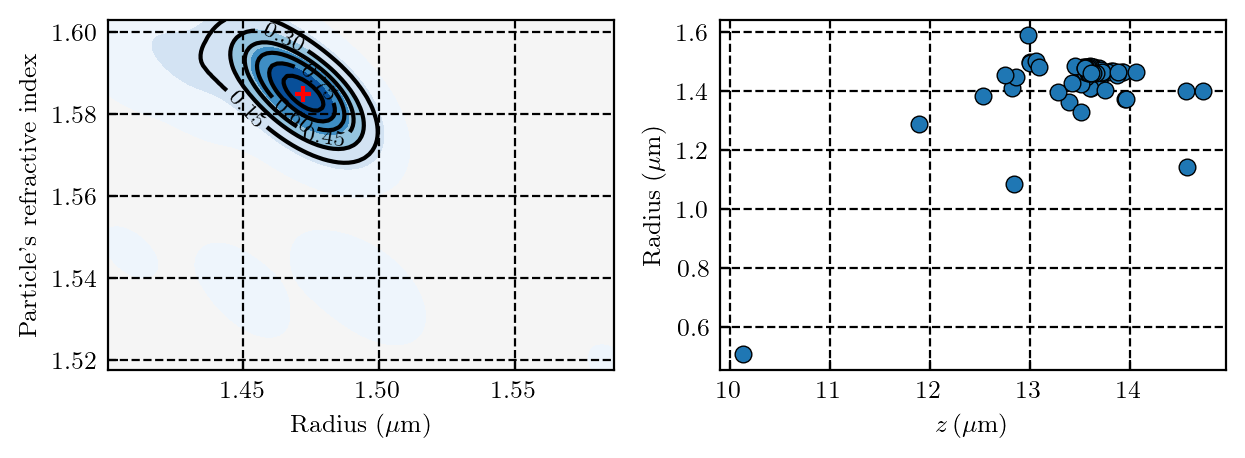

In [221]:
fig, axes = plt.subplots(1, 2, figsize=(16/2.54, 6/2.54))

# By default, seaborn kdeplot uses the same bw method as scipy.stats.gaussian_kde
axes[0].set_facecolor((0.3, 0.3, 0.3, 0.05))
axes[0].grid(visible=True, axis="both", linestyle="--", c='k')
sns.kdeplot(data=storage[(storage['r'] >= rmin) & (storage['r'] <= rmax)], x='r', y='n', hue=None, fill=True, levels=6, cmap='Blues', ax=axes[0])

axes[0].set_xlim(xmin, xmax)
axes[0].set_ylim(ymin, ymax)
# cfset = axes[0].contourf(xx, yy, f, cmap='Blues')
cset = axes[0].contour(xx, yy, f, colors='k')
axes[0].clabel(cset, inline=1, fontsize=8)

axes[0].scatter(mu_r, mu_n, color = "red", marker="+")

axes[0].set(xlabel=r'Radius ($\mathrm{\mu m}$)', ylabel="Particle's refractive index")

axes[1].plot(storage['z'], storage['r'], ls='', marker='o')
axes[1].set(xlabel=r'$z \, \mathrm{(\mu m)}$', ylabel=r'Radius ($\mathrm{\mu m}$)')
axes[1].grid(visible=True, axis="both", linestyle="--", c='k')

plt.tight_layout()
plt.show()

In [222]:
print(mu_r, sigma_r)
print(mu_n, sigma_n)

1.471870867838538 0.014327134408549921
1.584864023995117 0.008239489252292547


## To Use Discrete Dipolar Approximation

In [242]:
# If you want to use ADDA, you need to add it to the path.
# This is done in the next few cells. 

In [243]:
# Choose a method 
# Either 'seq', 'mpi', or 'ocl'
method = 'mpi'

In [252]:
# Remove adda methods already in path

# sys.path controls paths for python
# os.environ['PATH'] controls machine paths (.bashrc file)

# Get all the paths in a list
paths = os.environ['PATH'].split(':') 
# Loop over the elements but knowing that the list paths will change
for i, path in enumerate(os.environ['PATH'].split(':')): 
    if 'adda' in path: 
        paths.remove(path)
# Recombine the paths
os.environ['PATH'] = ":".join(paths)

# while 'adda' in os.environ["PATH"]:
#     os.environ['PATH'] = ":".join(os.environ["PATH"].split(":")[:-1])

print(os.environ['PATH'])

/home/n.fares/.conda/envs/holopy-devel/bin:/usr/opt/anaconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/usr/opt/anaconda3/bin:/opt/pylon/bin:/snap/bin


In [253]:
os.environ['PATH'] += ''.join([':/home/n.fares/adda/src/', 'seq'])
os.environ['PATH'] += ''.join([':/home/n.fares/adda/src/', 'mpi'])
os.environ['PATH'] += ''.join([':/home/n.fares/adda/src/', 'ocl'])

In [254]:
print(os.environ["PATH"])

/home/n.fares/.conda/envs/holopy-devel/bin:/usr/opt/anaconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/usr/opt/anaconda3/bin:/opt/pylon/bin:/snap/bin:/home/n.fares/adda/src/seq:/home/n.fares/adda/src/mpi:/home/n.fares/adda/src/ocl


## Define the Sphere ``by Hand''

In [255]:
# Define holograms 
# Raw image
holo_raw.data[:,:,0] = copy.deepcopy(im_raw)
# Background-corrected image
holo = bg_correct(holo_raw, background, df=None)
# Cropped and normalized image
holo_c, xc, yc = full2crop(holo, hc=hc)

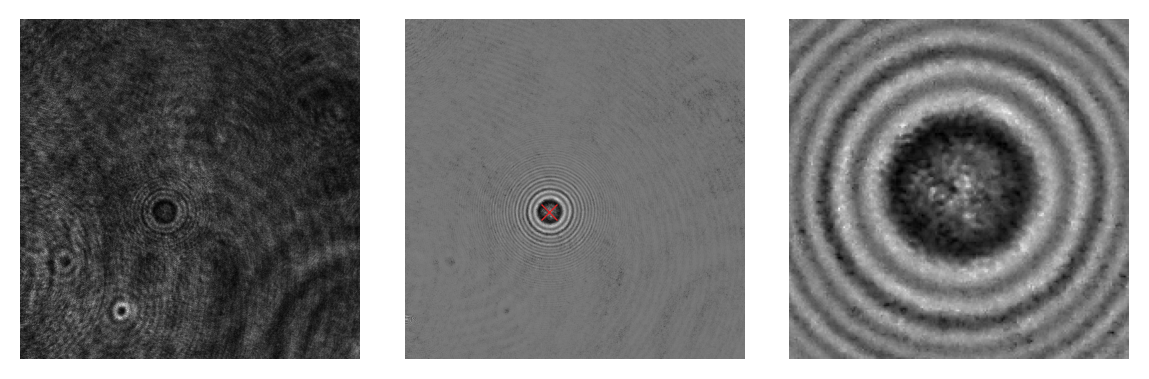

In [256]:
fig, axes = plt.subplots(1, 3, figsize=(15/2.54, 5/2.54))
axes[0].imshow(holo_raw.data, cmap='gray')
axes[1].imshow(holo.data, cmap='gray')
axes[1].plot(yc, xc, marker='x', mec='tab:red')
axes[2].imshow(holo_c.data, cmap='gray')
for i, ax in enumerate(axes):
    ax.axis('off')
plt.tight_layout()
plt.show()

In [277]:
%%time 

# Parameters you want to fit are defined as prior guesses 
x_p = prior.Uniform(lower_bound=xc*spacing-5, upper_bound=xc*spacing+5, guess=xc*spacing)
y_p = prior.Uniform(lower_bound=yc*spacing-5, upper_bound=yc*spacing+5, guess=yc*spacing)
z_p = prior.Uniform(lower_bound=10, upper_bound=15, guess=12)
# a_p = prior.Gaussian(1.5, 0.05)
# n_p = prior.Gaussian(1.59, 0.005)
a_p = prior.Uniform(1.46, 1.50, 1.48)
n_p = prior.Uniform(1.58, 1.60, 1.588)

# Define the sphere
par_sphere = Sphere(n=n_p, r=a_p, center=[x_p, y_p, z_p])

# Define the theory
theory = Mie
# DDA(n_cpu=1, use_gpu=False) 
# 'auto', Mie, Tmatrix for a sphere.

# Define the model 
model = ExactModel(
    scatterer=par_sphere, calc_func=calc_holo, 
    noise_sd=None, 
    medium_index=medium_index, illum_wavelen=illum_wavelen, illum_polarization=illum_polarization, 
    theory=theory,
    constraints=[], 
    )
# noise_sd can be set to None if all the prior variables are Uniform(). 
# Otherwise noise_sd must be set to something...

# model._parameter_names = ['r', 'x', 'y', 'z']

# Define the fit strategy
fit_strategy = NmpfitStrategy()
fit_strategy.npixels = int(percent_px * hc ** 2)
# fit_strategy = CmaStrategy(popsize=1)
# fit_strategy.resample_pixels = True
# fit_strategy.parallel = 'mpi'
# fit_strategy.seed = 1000

CPU times: user 409 µs, sys: 0 ns, total: 409 µs
Wall time: 412 µs


In [278]:
%%time 

# Fit 
fit_result0 = hp.fit(holo_c, model=model, strategy=fit_strategy) 
# Parameters to fit are included in the model through the prior objects. 

CPU times: user 3.97 s, sys: 0 ns, total: 3.97 s
Wall time: 3.97 s


{'n': 1.5817325814048184, 'r': 1.4784818522137306, 'center.0': 39.40823020540389, 'center.1': 29.630521597552658, 'center.2': 13.57627534592369}


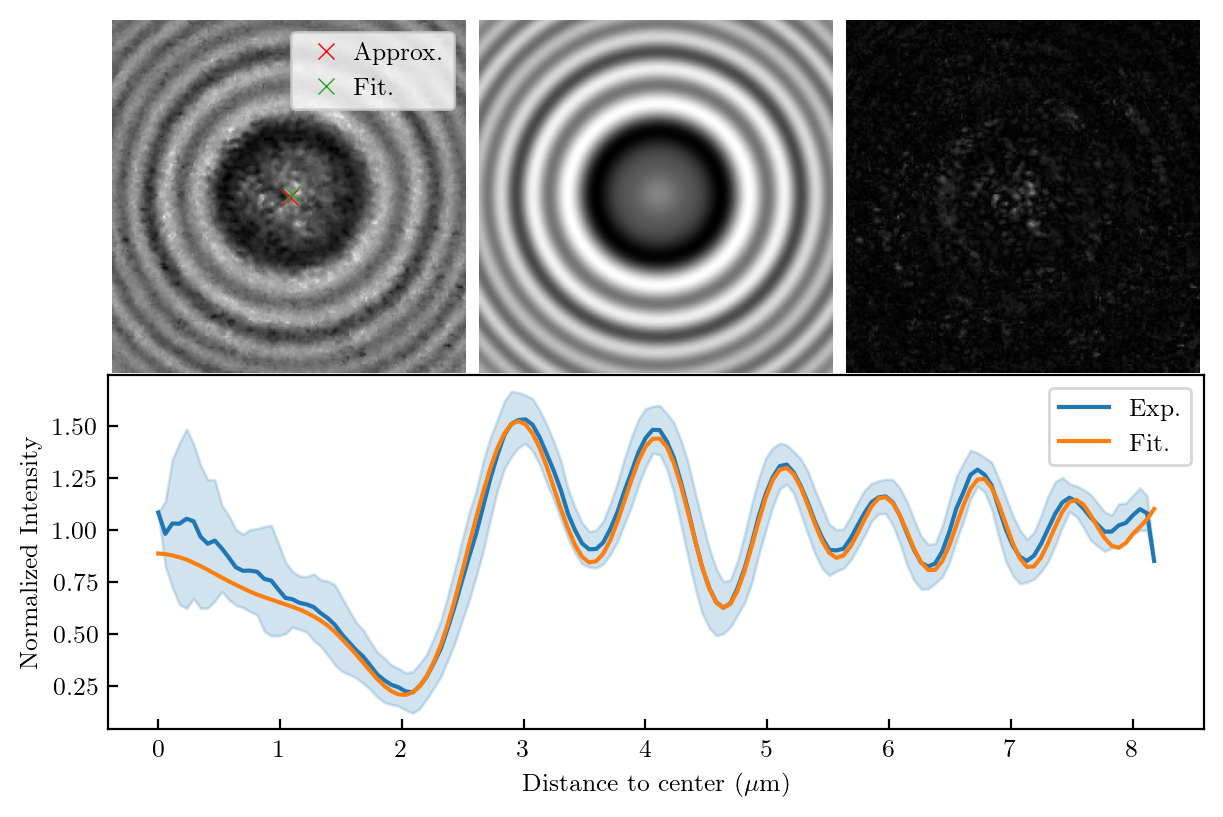

In [279]:
print(fit_result0.parameters)

holo_f = fit_result0.hologram

fig = plt.figure(figsize=(15/2.54,10/2.54))
nlin, ncol = 2, 3

# Plot images
ax1 = fig.add_subplot(nlin, ncol, 1)
ax2 = fig.add_subplot(nlin, ncol, 2)
ax3 = fig.add_subplot(nlin, ncol, 3)
ax1.imshow(holo_c.data, cmap='gray')
ax2.imshow(holo_f, cmap='gray')
ax3.imshow(np.abs(holo_c.data - holo_f.data), cmap='gray', vmin=0, vmax=2)
for ax in [ax1, ax2, ax3]:
    ax.axis('off')

# Compute radial intensity profiles 
expe_rad, expe_avg, expe_std = aziavgstd(holo_c.data, [hc//2, hc//2]) 
theo_rad, theo_avg, _ = aziavgstd(holo_f.data, [hc//2, hc//2]) 
expe_rad = expe_rad * spacing 
theo_rad = theo_rad * spacing 

ax1.plot(hc//2, hc//2, ls='', marker='x', mec='r', label='Approx.')
ax1.plot(fit_result0.parameters['center.1']/spacing - yc + hc//2, fit_result0.parameters['center.0']/spacing - xc + hc//2, ls='', marker='x', mec='tab:green', label='Fit.')
ax1.legend(handletextpad=0.1)

# Plot radial intensity profile
ax4 = fig.add_subplot(nlin, ncol, (4,6))
ax4.plot(expe_rad, expe_avg, ls='-', c='tab:blue', label='Exp.')
ax4.fill_between(expe_rad, expe_avg-expe_std, expe_avg+expe_std, color='tab:blue', alpha=0.2)
ax4.plot(theo_rad, theo_avg, ls='-', c='tab:orange', label='Fit.')
ax4.legend()
ax4.set(xlabel=r'Distance to center ($\mathrm{\mu m}$)', ylabel=r'Normalized Intensity')
plt.tight_layout(pad=0.2)
plt.show()